In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

from jax.scipy.stats.gamma import sf as gamma_sf
from jax.scipy.stats.norm import pdf as norm_pdf
from jax.scipy.stats.gamma import pdf as gamma_pdf

from lib.gamma_sf_approx import gamma_sf_fast, gamma_sf_fast_w_existing_coefficients, c_coeffs

In [2]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [3]:
import quadax
from quadax import quadgk
from quadax import quadgk as quad
#from quadax import quadts as quad
#from quadax import quadcc as quad


In [4]:
from lib.c_mpe_gamma import c_multi_gamma_mpe_prob_pure_jax, c_multi_gamma_mpe_prob_pure_jax_fast

convolved_mpe_triple_gamma_fast_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax_fast, (0, None, None, None, None, None), 0))
convolved_mpe_triple_gamma_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax, (0, None, None, None, None, None), 0))

In [5]:
dist = 10
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[1.15534134 3.76605356 1.00011428] [0.03971155 1.00413749 0.00229017]


In [6]:
def c_multi_gamma_mpe_prob_midpoint(x, mix_probs, a, b, n, sigma=3.0):
    nmax = 10
    nint1 = 5
    nint2 = 15
    nint3 = 21
    eps = 1.e-6

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    x_m1 = xmin + 0.02*sigma
    x_m2 = x_m1 + 0.5*sigma

    # two combined the two integration regions
    xvals = jnp.concatenate([jnp.linspace(xmin, x_m1, nint1), 
                             jnp.linspace(x_m1, x_m2, nint2),
                             jnp.linspace(x_m2, xmax, nint3)])
    
    dx = xvals[1:]-xvals[:-1]
    
    xvals = 0.5*(xvals[:-1]+xvals[1:])
    n_pdf = norm_pdf(xvals, loc=x, scale=sigma)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)

    xvals_e = jnp.expand_dims(xvals, axis=0)
    sfs_power = jnp.power(jnp.sum(mix_probs_e * gamma_sf_fast(xvals_e, a_e, b_e), axis=0), n-1.0)
    pdfs = jnp.sum(mix_probs_e * gamma_pdf(xvals_e, a_e, scale=1./b_e), axis=0)
    
    return jnp.sum(n_pdf * n * pdfs * sfs_power * dx)

c_multi_gamma_mpe_prob_midpoint_v = jax.vmap(c_multi_gamma_mpe_prob_midpoint, (0, None, None, None, None, None), 0)

In [7]:
@jax.jit
def integrand_fast(x, mix_probs, a, b, n_p, sigma, x0):
    c = c_coeffs(a)
    
    g_pdf = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                        probs=mix_probs
                      ),
                  components_distribution=tfd.Gamma(
                        concentration=a,
                        rate=b,
                        force_probs_to_zero_outside_support=True
                      )
                )

    tmp = jnp.sum(mix_probs * gamma_sf_fast_w_existing_coefficients(x, a, b, c), axis=-1)
    return norm_pdf(x, loc=x0, scale=sigma) * g_pdf.prob(x) * n_p * jnp.power(tmp, n_p-1.0)

@jax.jit
def c_multi_gamma_mpe_prob_pure_jax_fast_qdx(x, mix_probs, a, b, n, sigma=3.0):
    delta = jnp.array(10.0)
    eps = 1.e-6
    xmax = jnp.max(jnp.array([delta*sigma, x + delta*sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0)+eps, x - diff]))

    
    res = quad(integrand_fast, 
                 jnp.array([xmin, xmax]), 
                 args=(mix_probs, a, b, n, sigma, x), 
                 epsabs=1.e-5, 
                 epsrel=1.e-5, 
                 order=31,
                 max_ninter=1
              )[0]
    '''
    res = quad(integrand_fast, 
                 jnp.array([xmin, xmax]), 
                 args=(mix_probs, a, b, n, sigma, x), 
              )[0]
    '''
    
    return res
    
c_multi_gamma_mpe_prob_pure_jax_fast_qdx_v = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax_fast_qdx, (0, None, None, None, None, None), 0))

In [8]:
@jax.jit
def integrand(x, mix_probs, a, b, n_p, sigma, x0):
    c = c_coeffs(a)
    
    g_pdf = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                        probs=mix_probs
                      ),
                  components_distribution=tfd.Gamma(
                        concentration=a,
                        rate=b,
                        force_probs_to_zero_outside_support=True
                      )
                )

    return norm_pdf(x, loc=x0, scale=sigma) * g_pdf.prob(x) * n_p * jnp.power(g_pdf.survival_function(x), n_p-1.0)

@jax.jit
def c_multi_gamma_mpe_prob_pure_jax_qdx(x, mix_probs, a, b, n, sigma=3.0):
    delta = jnp.array(10.0)
    eps = 1.e-6
    xmax = jnp.max(jnp.array([delta*sigma, x + delta*sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0)+eps, x - diff]))
    
    res = quad(integrand, 
                 jnp.array([xmin, xmax]), 
                 args=(mix_probs, a, b, n, sigma, x), 
                 epsabs=1.e-5, 
                 epsrel=1.e-5, 
                 order=31,
                 max_ninter=1
              )[0]
    
    return res

c_multi_gamma_mpe_prob_pure_jax_qdx_v = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax_qdx, (0, None, None, None, None, None), 0))

/home/hans/.local/share/virtualenvs/py3_jax_latest-mr9UFGRS/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/hans/.local/share/virtualenvs/py3_jax_latest-mr9UFGRS/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


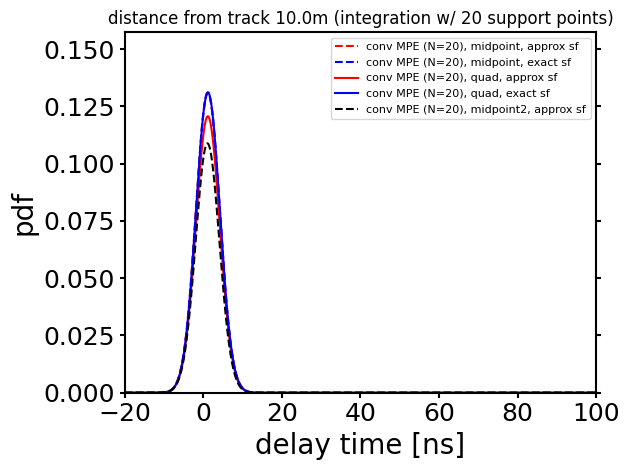

In [9]:
from matplotlib.pyplot import cm

n_p = 20

fig, ax = plt.subplots()
xvals = np.linspace(-20, 100, 100000)

y_max = 0
n_photons = jnp.array(np.linspace(1,21, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

ys = convolved_mpe_triple_gamma_fast_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), midpoint, approx sf', color='red', linestyle='dashed')
y_max = np.amax([y_max, np.amax(ys)])

ys = convolved_mpe_triple_gamma_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), midpoint, exact sf', color='blue', linestyle='dashed')
y_max = np.amax([y_max, np.amax(ys)])

ys = c_multi_gamma_mpe_prob_pure_jax_fast_qdx_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), quad, approx sf', color='red', linestyle='solid')
y_max = np.amax([y_max, np.amax(ys)])

ys = c_multi_gamma_mpe_prob_pure_jax_qdx_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), quad, exact sf', color='blue', linestyle='solid')
y_max = np.amax([y_max, np.amax(ys)])

ys = c_multi_gamma_mpe_prob_midpoint_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), midpoint2, approx sf', color='black', linestyle='dashed')
y_max = np.amax([y_max, np.amax(ys)])

plot_args = {'xlim':[-20, 100],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

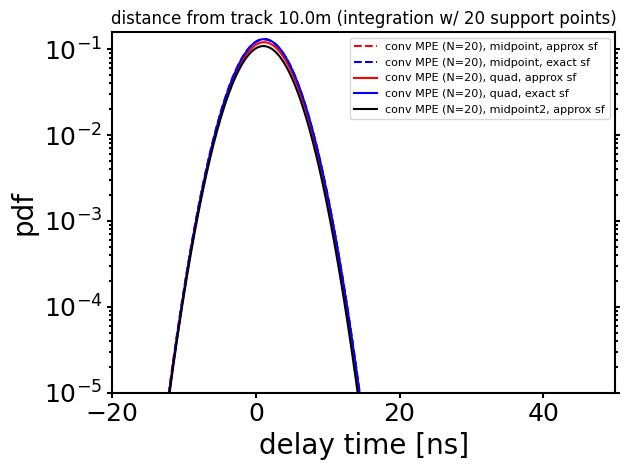

In [10]:
from matplotlib.pyplot import cm

n_p = 20

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 100000)

y_max = 0
n_photons = jnp.array(np.linspace(1,21, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

ys = convolved_mpe_triple_gamma_fast_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), midpoint, approx sf', color='red', linestyle='dashed')
y_max = np.amax([y_max, np.amax(ys)])

ys = convolved_mpe_triple_gamma_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), midpoint, exact sf', color='blue', linestyle='dashed')
y_max = np.amax([y_max, np.amax(ys)])

ys = c_multi_gamma_mpe_prob_pure_jax_fast_qdx_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), quad, approx sf', color='red', linestyle='solid')
y_max = np.amax([y_max, np.amax(ys)])

ys = c_multi_gamma_mpe_prob_pure_jax_qdx_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), quad, exact sf', color='blue', linestyle='solid')
y_max = np.amax([y_max, np.amax(ys)])

ys = c_multi_gamma_mpe_prob_midpoint_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), midpoint2, approx sf', color='black', linestyle='solid')
y_max = np.amax([y_max, np.amax(ys)])

plot_args = {'xlim':[-20, 50],
                     'ylim':[1.e-5, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_yscale('log')
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_433512/423270230.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


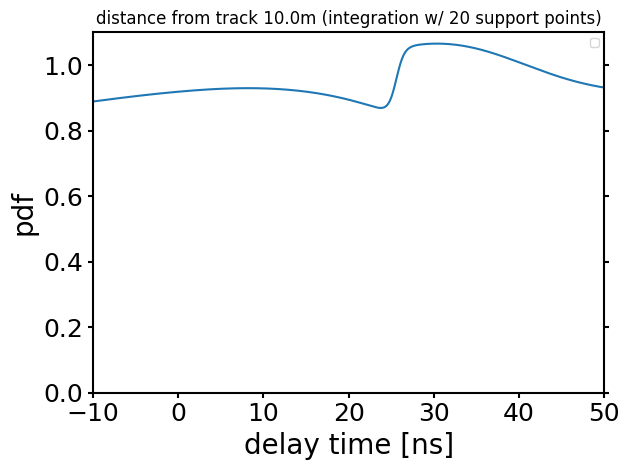

In [11]:
ys_q = c_multi_gamma_mpe_prob_pure_jax_fast_qdx_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
ys_f = convolved_mpe_triple_gamma_fast_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
fig, ax = plt.subplots()
ax.plot(xvals, jnp.clip(ys_q/ys_f ,min=0, max=2))
plot_args = {'xlim':[-10, 50],
                     'ylim':[0.0, 1.1],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [12]:
@jax.jit
def compute_approx_mpe_pdf(x):
    return c_multi_gamma_mpe_prob_pure_jax_fast_qdx(x, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

@jax.jit
def compute_mpe_pdf(x):
    return c_multi_gamma_mpe_prob_pure_jax_qdx(x, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

In [13]:
print(quadgk(compute_approx_mpe_pdf, [-30.0, 2000]))

(Array(0.92041609, dtype=float64), QuadratureInfo(err=Array(6.88079269e-09, dtype=float64), neval=Array(441, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))


In [14]:
print(quadgk(compute_mpe_pdf, [-30.0, 2000]))

(Array(1.00003862, dtype=float64), QuadratureInfo(err=Array(1.34493621e-08, dtype=float64), neval=Array(399, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))


In [15]:
@jax.jit
def compute_approx_mpe_pdf(x):
    return c_multi_gamma_mpe_prob_pure_jax_fast(x, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

@jax.jit
def compute_mpe_pdf(x):
    return c_multi_gamma_mpe_prob_pure_jax(x, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

In [16]:
print(quadgk(compute_approx_mpe_pdf, [-30., 2000]))

(Array(1.0000893, dtype=float64), QuadratureInfo(err=Array(1.00012924e-08, dtype=float64), neval=Array(441, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))


In [17]:
print(quadgk(compute_mpe_pdf, [-30.0, 2000]))

(Array(1.00007939, dtype=float64), QuadratureInfo(err=Array(9.70295476e-09, dtype=float64), neval=Array(441, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))


In [18]:
%timeit c_multi_gamma_mpe_prob_pure_jax_fast_qdx_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

29.8 ms ± 5.98 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit convolved_mpe_triple_gamma_fast_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

16.1 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit convolved_mpe_triple_gamma_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

687 ms ± 429 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit c_multi_gamma_mpe_prob_pure_jax_qdx_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

1.07 s ± 182 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%timeit c_multi_gamma_mpe_prob_midpoint_v(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

24.7 ms ± 549 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
